<h2>Simulation of Thermal Conduction and Convection</h2>

<h3>Introduction</h3>

This document is a "jupyter notebook", which contains "cells" of python code interspersed with text that can explain, comment on, or discuss the code and its results.  This particular notebook builds up a three-dimensional simulation of thermal convection and conduction, starting with an oversimplified model of the time required to change the temperature of an object in one-dimension and ending with a simulation of the full heat equation combined with convection in three dimensions.  The notebook assumes knowledge of thermal physics, such as the definition of specific heat, the thermal conduction equation, and the convection equation, as well as basic knowledge of python.<br>

<h3>One-dimensional System, No Convection</h3>

<i>Constant Uniform Temperature</i>

Start by importing various libraries (aka modules or packages) of useful functions.  These functions will be used later in the notebook.  Remember that anything after a "#" is a comment not code.  To run a particular code cell, click on the play symbol at the upper-left of the cell.  In a notebook, you can run or rerun a cell without running the rest of the code in the notebook.  This feature gives you great flexibility in revising and testing code.

In [2]:
import numpy as np    # contains many useful calculation functions
import scipy.ndimage as im    # image processing, used for the convolution method
import matplotlib.pyplot as plt   # functions for making plots
# the next line makes the plots appear properly within the notebook
%matplotlib inline    
import time    # contains a function used to time the various method of calculation

We begin by looking at a metal rod, heated at one end by exposure to a constant high temperature, and finding the time needed for the other end to reach a certain temperature.  This situation is inspired by problem 1.60 in "An Introduction to Thermal Physics" by Daniel V. Schroeder.

First we treat the rod as having a uniform temperature, calculating the energy needed for the rod to reach that final temperature, then using the thermal conduction equation to find the energy flow rate and hence the time needed to reach the final temperature.  The numbers in this portion are for an aluminum bar increasing temperature to 100 deg C, if one end is in contact with 500 deg C.


In [32]:
kth = 205        # thermal conductivity, W/(m*K)
specHeat = 900    # specific heat, J/(kg*K)
T0 = 22           # initial temperature, deg C
Tout = 500          # outside temperature, deg C
TEnd = 100         # final temperature, deg C
L = 0.25          # length, m
A = 0.5*0.5 * (2.54)**2 * (0.01)**2    # cross section area, inches squared converted to m^2
volume = L * A
density = 2.7e3       # density, kg/m^3
mass = volume * density

Now calculate and plot the time needed to reach various final temperatures.  As an exercise, you should derive each of the three calculation lines.

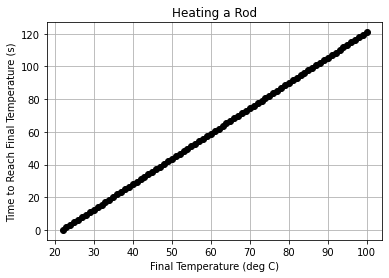

Time needed to reach 100 deg C is 120.89243800387796 s


In [33]:
for Tfinal in range(T0,TEnd+1):    # integer values, add 1 because of how a python loop works
    energy = (Tfinal-T0) * mass * specHeat
    flowRate = (Tout-T0) * kth * A / L
    timeNeeded = energy / flowRate
    plt.plot(Tfinal,timeNeeded,'ko')
plt.ylabel("Time to Reach Final Temperature (s)")
plt.xlabel("Final Temperature (deg C)")
plt.title("Heating a Rod")
plt.grid(which="both",axis="both")
plt.show()
print("Time needed to reach",Tfinal,"deg C is",timeNeeded,"s")

<i>Changing Uniform Temperature</i>

The flaw is that we assumed the energy flow was constant.  Actually, the energy flow depends on the temperature difference between the heated end and the rest of the rod.  So, we instead need to track temperature vs time, with small time intervals, as the temperature difference changes.  We thus effectively produce a new plot of final temperature vs time.  As an exercise, predict how the revised calculation will affect the time needed to reach a particular temperature.  As another exercise, derive and solve the differential equation for the time rate of change of the temperature, and plot the solution also.

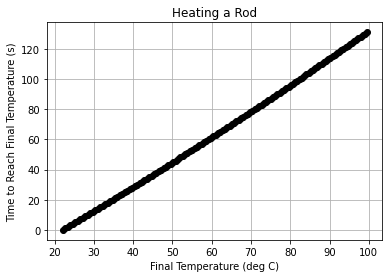

Time needed to reach 100 deg C is 132 s


In [34]:
t = 0
dt = 1            # time step, s
temp = T0
while temp <= TEnd:
    plt.plot(temp,t,'ko')
    t += dt
    flowRate = kth * A * (Tout - temp) / L
    temp += flowRate * dt / (mass * specHeat)
plt.ylabel("Time to Reach Final Temperature (s)")
plt.xlabel("Final Temperature (deg C)")
plt.title("Heating a Rod")
plt.grid(which="both",axis="both")
plt.show()
print("Time needed to reach",TEnd,"deg C is",t,"s")


<i>Nonuniform Temperature, Loop over Position</i>

Now it is time to include the fact that different parts of the rod will have different temperatures.  Now the object will be treated as chunks and energy flow occurs at both sides of each chunk.  One end is in contact with Tout as before.  We must also use a boundary condition at the unheated end, which we will treat as insulated.  For this cell, we will implement the calculations with nested loops, one over time as before and the other over position.

The code calculates and prints the running time, for comparison with another method of doing the temperature calculations.

For an exercise, you can derive the calculation equations.  You can also take the limit and derive the heat equation.

For an exercise, you can look at the algebra of the quantity alpha and show that the area drops out, and you can use alpha in the calculations to make them look simpler.  If alpha is too large (larger than 0.5), then the roundoff error in the calculations leads to unphysical instability in the temperature versus time (try it).

alpha = 0.08436213991769548
Time for end to reach  100 deg C is 122.09999999999734 s
run time 1.1307416999998168 s


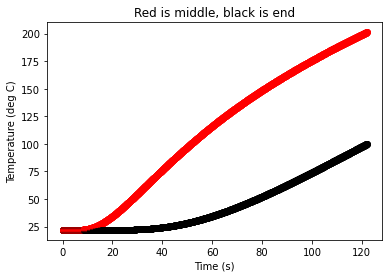

In [39]:
start = time.perf_counter()   # store the starting time of running the code

t = 0
dt = 0.1            # time step, s
n = 25           # number of position chunks
tempList = [T0] * n    # list of temperatures at the positions
dx = L / n          # distance chunk, m

A = 0.5*0.5 * (2.54)**2 * (0.01)**2    # cross section area, inches squared converted to m^2
dV = dx * A                              # volume of chunk
density = 2.7e3       # density, kg/m^3
dM = dV * density    # mass of chunk

while tempList[-1] <= TEnd:
    temp = tempList.copy()
    plt.plot(t,temp[-1],'ko')
    plt.plot(t,temp[int(len(temp)/2)],'ro')
    t += dt
# derive these equations
    # end in contact with hot thing
    flowRate = kth * A * ((Tout - tempList[0]) / dx - (tempList[0] - tempList[1]) / dx)
    temp[0] += flowRate * dt / (dM * specHeat)
    # insulated end, force dT/dx to be zero by reflecting the temperature
    flowRate = 2 * kth * A * (tempList[-2] - tempList[-1]) / dx
    temp[-1] += flowRate * dt / (dM * specHeat)
    # rest of the object
    for i in range(1,len(temp)-1):
        flowRate = kth * A * ((tempList[i-1] - tempList[i]) / dx - (tempList[i] - tempList[i+1]) / dx)
        temp[i] += flowRate * dt / (dM * specHeat)
    tempList = temp.copy()
alpha = kth*A*dt/(dx*dM*specHeat)
print("alpha =",alpha)
if alpha >= 0.5:
    print("alpha larger than 0.5, results may be unstable")
print("Time for end to reach ",TEnd,"deg C is",t,"s")
stop = time.perf_counter()
print("run time",stop-start,"s")
plt.title("Red is middle, black is end")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (deg C)")
plt.show()

<i>Nonuniform Temperature, Matrix Multiplication</i>

Now we do the calculations again, but now storing the temperatures in a one-dimensional array (vector) and using a matrix multiplying the vector instead of a loop over positions.  We switch from a python list to a numpy array to use numpy functions, making the temperature array one larger than the previous list so we can use the first element as the constant temperature outside the object.

For an exercise, you can derive the elements of the two-dimensional matrix.  You will need to understand how matrix multiplication works.

Which method of doing the calculations is faster?

alpha =  0.08436213991769548
run time 1.1573585999999523 s
Time for end to reach  100 deg C is 122.09999999999734 s


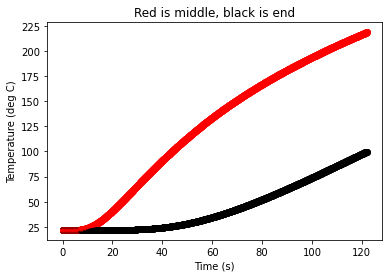

In [40]:
start = time.perf_counter()
t = 0

tempVector = np.array([Tout]+[T0]*n)    # converts a python list to a numpy array, for faster calculations

alpha = dt * kth / (specHeat * density * dx**2)    # exercise: derive this
print("alpha = ", alpha)
if alpha > 0.5:
    print("results may be unstable, reduce time step")
updateTDiag = np.diag(np.full(n+1,1-2*alpha))   # exercise:  derive this
updateTDiag[0,0] = 1      # the outside temperature does not change
updateTOffDiag = np.diag(np.ones(n),1) + np.diag(np.ones(n),-1)    # exercise:  derive these five lines
updateTOffDiag[-1,-2] = 2   # adiabatic at the other end
updateTOffDiag[0,1] = 0      # no conduction to the outside temp
updateTOffDiag *= alpha
#print(updateTDiag)
#print(updateTOffDiag)
updateT = updateTDiag + updateTOffDiag   # this is the full matrix that will multiply the temperature array

while tempVector[-1] <= TEnd:
    plt.plot(t,tempVector[-1],'ko')    # end plots in black
    plt.plot(t,tempVector[int(len(temp)/2)],'ro')    # middle plots in red
    t += dt
    tempVector = np.matmul(updateT,tempVector)  # each time step is calculated using matrix multiplying the temperatures
stop = time.perf_counter()
print("run time",stop-start,"s")
print("Time for end to reach ",TEnd,"deg C is",t,"s")
plt.title("Red is middle, black is end")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (deg C)")
plt.show()

<h3>Conduction with Convection, One-Dimensional</h3>

<i>Loop over Position</i>

Now we simulate something in boiling water, an oven, or other situation where both ends are in contact with a liquid or gas at  some higher temperature.  We must now add a convection at the ends, to simulate the energy transfer from the fluid to the object.  We can boil a potato, still one-dimensional so, for instance, this could be a slice of potato with small thickness compared to its other two dimensions.

This time, we run for a set time (15 minutes).  To run until the middle reaches a certain temperature, substitute the commented portion of the loop condition.  First, we do the calculations with nested loops.

alpha = 0.044247787610619475
at time 900.0000000001361 s the middle is at temperature 33.839374479734765 deg C
run time 9.164895400000205 s


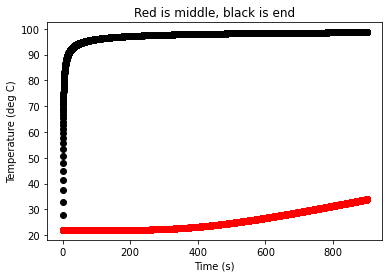

In [43]:
start = time.perf_counter()
kth = 0.75        # thermal conductivity, W/(m*K)
h = 5000           # convection coefficient, W/(m^2*K)
specHeat = 3390    # specific heat, J/(kg*K)
T0 = 22           # initial temperature, deg C
Tout = 100          # outside temperature, deg C
L = 0.025          # length, m
density = 630       # density, kg/m^3
Tfinal = 99       # ending temperature, deg C
t = 0
dt = 0.1            # time step, s
n = 100           # number of position chunks
tempList = [T0] * n    # list of temperatures at the positions
dx = L / n          # distance chunk, m

A = 4*L*L    # cross section area
dV = dx * A                              # volume of chunk
density = 8e3       # density, kg/m^3
dM = dV * density    # mass of chunk

tTotal = 60 * 15   # total time, 15 minutes, in s
while t <= tTotal:        #tempList[-1] <= Tfinal:
    temp = tempList.copy()
    plt.plot(t,temp[-1],'ko')
    plt.plot(t,temp[int(len(temp)/2)],'ro')
    t += dt
    # ends in contact with hot thing
    flowRate = h * A * (Tout - tempList[0]) + kth * A * (- (tempList[0] - tempList[1]) / dx)
    temp[0] += flowRate * dt / (dM * specHeat)
    flowRate = h * A * (Tout - tempList[-1]) + kth * A * (- (tempList[-1] - tempList[-2]) / dx)
    temp[-1] += flowRate * dt / (dM * specHeat)
    # rest of the object
    for i in range(1,len(temp)-1):
        flowRate = kth * A * ((tempList[i-1] - tempList[i]) / dx - (tempList[i] - tempList[i+1]) / dx)
        temp[i] += flowRate * dt / (dM * specHeat)
    tempList = temp.copy()
print("alpha =",kth*A*dt/(dx*dM*specHeat))

print("at time",t,"s the middle is at temperature",tempList[int(len(tempList)/2)],"deg C")

stop = time.perf_counter()
print("run time",stop-start,"s")
plt.title("Red is middle, black is end")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (deg C)")
plt.show()

<i>Matrix Multiplication</i>

Now do the calculations with matrices.  Which method is faster?

alpha =  0.04424778761061948
convect = 0.07374631268436578
900.0000000001361 33.839374479734786
run time 8.89575110000078 s


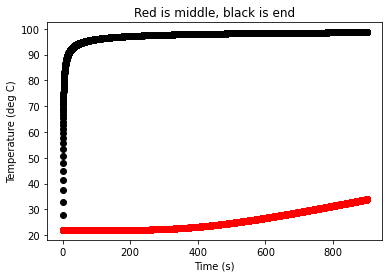

In [45]:
start = time.perf_counter()
t = 0

tempVector = np.array([Tout]+[T0]*n+[Tout])    

alpha = dt * kth / (specHeat * density * dx**2)    # exercise: derive this
convect = h * dt / (specHeat * density * dx)
print("alpha = ", alpha)
print("convect =", convect)
if alpha > 0.5:
    print("results may be unstable, reduce time step")
updateTDiag = np.diag(np.full(n+2,1-2*alpha))   # exercise:  derive this
updateTDiag[1,1] = 1-alpha-convect     # convection at surfaces
updateTDiag[-2,-2] = 1-alpha-convect
updateTDiag[0,0] = 1      # the outside temperature does not change
updateTDiag[-1,-1] = 1
updateTOffDiag = np.diag(np.ones(n+1),1) + np.diag(np.ones(n+1),-1)    # exercise:  derive these five lines
updateTOffDiag[0,1] = 0      # no conduction to the outside temp
updateTOffDiag[-1,-2] = 0
updateTOffDiag *= alpha
updateTOffDiag[1,0] = convect     # convection at surface
updateTOffDiag[-2,-1] = convect
#print(updateTDiag)
#print(updateTOffDiag)
updateT = updateTDiag + updateTOffDiag
#print(updateT)
while t <= tTotal:     # tempVector[-1] <= Tfinal:
    plt.plot(t,tempVector[-2],'ko')    # end plots in black
    plt.plot(t,tempVector[int(len(temp)/2)],'ro')    # middle plots in red
    t += dt
    tempVector = np.matmul(updateT,tempVector)

print(t,tempVector[int(len(tempVector)/2)])
stop = time.perf_counter()
print("run time",stop-start,"s")
plt.title("Red is middle, black is end")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (deg C)")
plt.show()

<h3>Conduction with Convection, Three-Dimensional</h3>

<i>Convolution</i>

Unfortunately, matrices won't work for a 2-d or 3-d system.  One can, however, use "convolution", which basically is like the matrix calculations in that it allows the calculation for changing the temperature at one place (one element of a 2-d or 3-d array) to depend on the neighbors, by setting up a "kernel" that is similar to the nonzero elements of the matrix we used before.  We will do a cubical piece of potato in full 3-d, first with the convolution calculation then with nested loops.  We use the function scipy.ndimage.convolve in mode 'nearest' to apply the convolution, which calculates the conduction.  Then, we loop over the faces to apply the convection from the outside.  The temperature array only includes the potato, not the water.

First some set up.  If you want to change the thermal properties later, you will need to change and rerun this cell, or copy this cell below and change it there.

In [46]:
t = 0
kth = 0.47        # thermal conductivity, W/(m*K)
h = 1500           # convection coefficient, W/(m^2*K)
specHeat = 3390    # specific heat, J/(kg*K)
T0 = 22           # initial temperature, deg C
Tout = 100          # outside temperature, deg C
L = 0.038          # length, m
density = 630       # density, kg/m^3
Tfinal = 99       # ending temperature, deg C

dt = 1            # time step, s
n = 11           # number of position chunks
dx = L / n          # distance chunk, m

alpha = dt * kth / (specHeat * density * dx**2)    # exercise: derive this
convect = h * dt / (specHeat * density * dx)
print("alpha = ", alpha)
print("convect =", convect)
if alpha > 0.5 or convect > 0.5:
    print("results may be unstable, reduce time step")

alpha =  0.018440631413445378
convect = 0.20331063647318887


Now do the convolution.  Using "nearest" mode for the conduction effectively keeps conduction from happening at the surface from the fluid.  Then, the convection at the surface is done separately, looping over each surface then looping at the chunks on each surface.  If you assume cubic symmetry and use slices, this part could probably be done quicker.

Understanding this code requires that you understand how indices and slicing work for a numpy array.

The code is set up to find the time for the center of the potato to reach a certain temperature, in this case 99 deg C, which is considered the optimal temperature.

running time 1.5430480000004536 s


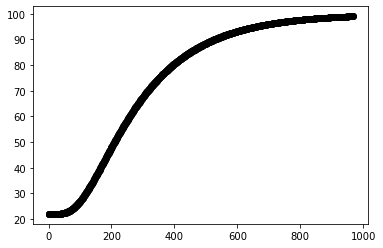

cooking time 968 seconds


In [47]:
start = time.perf_counter()
    
temp = np.zeros((n,n,n)) + T0
    
# set up the kernel for the convolution
p = np.zeros((3,3,3))
p[1][1][1] = -6
for i in [0,2]:
    p[i][1][1] = 1
    p[1][i][1] = 1
    p[1][1][i] = 1
p *= alpha
p[1][1][1] += 1

while temp[int(n/2)][int(n/2)][int(n/2)] <= Tfinal:    # t <= 30*60:
    #print(t,temp[int(n/2)][int(n/2)][int(n/2)])
    plt.plot(t,temp[int(n/2)][int(n/2)][int(n/2)],'ko')
    oldTemp = temp.copy()
    temp = im.convolve(temp,p,mode='nearest')  

    for i in [0,n-1]:
        for j in range(n):
            for k in range(n):
                temp[i][j][k] += convect * (Tout - oldTemp[i][j][k])
    for j in [0,n-1]:
        for i in range(n):
            for k in range(n):
                temp[i][j][k] += convect * (Tout - oldTemp[i][j][k])
    for k in [0,n-1]:
        for j in range(n):
            for i in range(n):
                temp[i][j][k] += convect * (Tout - oldTemp[i][j][k])
    
    t += dt

stop = time.perf_counter()
print("running time",stop-start,"s")
plt.show()
print("cooking time",t,"seconds")

Let's do that again, using cubic symmetry and slices to speed it up.

running time 0.5050521000002846 s


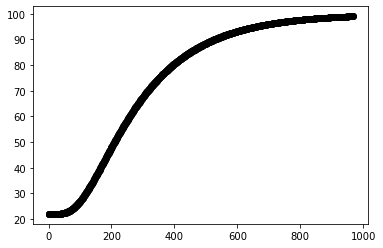

cooking time 968 seconds


In [48]:
start = time.perf_counter()
    
temp = np.zeros((n,n,n)) + T0
t = 0
    
# set up the kernel for the convolution
p = np.zeros((3,3,3))
p[1][1][1] = -6
for i in [0,2]:
    p[i][1][1] = 1
    p[1][i][1] = 1
    p[1][1][i] = 1
p *= alpha
p[1][1][1] += 1

while temp[int(n/2)][int(n/2)][int(n/2)] <= Tfinal:    # t <= 30*60:
    #print(t,temp[int(n/2)][int(n/2)][int(n/2)])
    plt.plot(t,temp[int(n/2)][int(n/2)][int(n/2)],'ko')
    oldTemp = temp.copy()
    temp = im.convolve(temp,p,mode='nearest')
    
    temp[0,:,:] += convect*(Tout - oldTemp[0,:,:])
    temp[-1:,:,:] += convect*(Tout - oldTemp[0,:,:])
    temp[:,-1,:] += convect*(Tout - oldTemp[0,:,:])
    temp[:,0,:] += convect*(Tout - oldTemp[0,:,:])
    temp[:,:,-1] += convect*(Tout - oldTemp[0,:,:])
    temp[:,:,0] += convect*(Tout - oldTemp[0,:,:])

    t += dt

stop = time.perf_counter()
print("running time",stop-start,"s")
plt.show()
print("cooking time",t,"seconds")

<br><i>Nested Loops</i>

Now with loops only.  Which way is faster?  For coding ease, assume that the cubic symmetry is maintained--each face is the same as each other face, every corner is the same, and every edge is the same.

running time 7.475439799999549 s


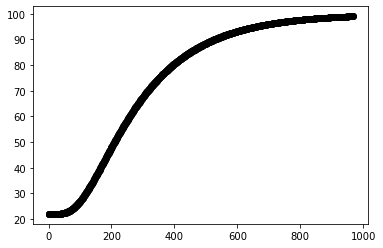

cooking time 968 seconds


In [49]:
start = time.perf_counter()
t = 0
temp = np.zeros((n,n,n)) + T0
while temp[int(n/2)][int(n/2)][int(n/2)] <= Tfinal:    # t <= 30*60:
    #print(t,temp[int(n/2)][int(n/2)][int(n/2)])
    plt.plot(t,temp[int(n/2)][int(n/2)][int(n/2)],'ko')
    oldTemp = temp.copy()
    
    # conduction in the inside
    for i in range(1,n-1):
        for j in range(1,n-1):
            for k in range(1,n-1):
                change = oldTemp[i+1][j][k] + oldTemp[i-1][j][k]
                change += oldTemp[i][j+1][k] + oldTemp[i][j-1][k]
                change += oldTemp[i][j][k+1] + oldTemp[i][j][k-1]
                change += -6 * oldTemp[i][j][k]
                temp[i][j][k] += change * alpha

    # convection
    for i in [0,n-1]:
        for j in range(n):
            for k in range(n):
                temp[i][j][k] += convect * (Tout - oldTemp[i][j][k])
    for j in [0,n-1]:
        for i in range(n):
            for k in range(n):
                temp[i][j][k] += convect * (Tout - oldTemp[i][j][k])
    for k in [0,n-1]:
        for j in range(n):
            for i in range(n):
                temp[i][j][k] += convect * (Tout - oldTemp[i][j][k])
    
    # conduction, interior of faces
    for i in range(1,n-1):
        for j in range(1,n-1):
            change = oldTemp[i+1][j][0] + oldTemp[i-1][j][0]
            change += oldTemp[i][j+1][0] + oldTemp[i][j-1][0]
            change += oldTemp[i][j][1]
            change += -5 * oldTemp[i][j][0]
            changeT = change * alpha
            temp[i][j][0] += changeT
            temp[i][j][-1] += changeT
            temp[0][j][i] += changeT
            temp[-1][j][i] += changeT
            temp[i][0][j] += changeT
            temp[i][-1][j] += changeT
            
    # conduction, corners, start with (0,0,0), assume cubic symmetry, then replicate to all corners
    change = -3*oldTemp[0][0][0] + 3*oldTemp[0][0][1]
    changeT = change * alpha
    for i in [0,-1]:
        for j in [0,-1]:
            for k in [0,-1]:
                temp[i][j][k] += changeT

    # conduction, edges, start with (0,0,*), assume cubic symmetry, then replicate to all edges
    for i in range(1,n-1):
        change = -4*oldTemp[0][0][i]
        change += 2*oldTemp[0][1][i]
        change += oldTemp[0][0][i-1] + oldTemp[0][0][i+1]
        changeT = change * alpha
        for j in [0,-1]:
            for k in [0,-1]:
                temp[i][j][k] += changeT
                temp[j][i][k] += changeT
                temp[k][j][i] += changeT
                
    t += dt

stop = time.perf_counter()
print("running time", stop-start, "s")
plt.show()
print("cooking time",t,"seconds")

<i>Comparison with Data</i>

Now we can read some data of temperature vs time.  If the time step in the data is different from the time step in the simulation, we can use the relevant points of the simulation to compute the chi-squared.  

This part depends on whether you are using anaconda or colaboratory, since the file-handling is more complicated for colaboratory.  The first code cell below reads the data file for anaconda (assuming the data is in the same folder as the notebook) and the second and third code cells are for colaboratory.  

The fourth cell runs the simulation again but saves the temperatures for times that match up with the times that the data was taken.  The fifth code cell plots the data with the simulation and calculates the chi-squared.

To improve the fit, try these steps:<br>
change the convection coefficient, since that has a large possible range;<br>
change the conductivity or the specific heat (result depends on the ratio);<br>
look up how the thermal properties of the potato vary with temperature and revise the previous code cell to incorporate that variation.

Run the next cell for anaconda.

In [4]:
# open file using anaconda
filename = "potato_data_july_8.txt"
timeData,tempData = np.loadtxt(filename,dtype='float',delimiter=',', unpack=True)
print(timeData,tempData)

[  0.  60. 120. 180. 240. 300. 360. 420. 480. 540. 600.] [24.1 25.5 32.2 43.3 54.8 64.6 72.2 80.3 86.1 89.6 92.4]


Run the next two cells for colaboratory.

In [ ]:
# open file using colaboratory (this cell and the next one)
from google.colab import files
uploaded = files.upload()

In [ ]:
# more for colaboratory
filename = "copy_file_name_here"   # copy the name given by the upload
timeData,tempData = np.loadtxt(filename,dtype='float',delimiter=',', unpack=True)

Now rerun the simulation and compare with the data.  The initial and water temperatures here come from the experiment.

running time 0.04518319999999676 s
cooking time 601 seconds


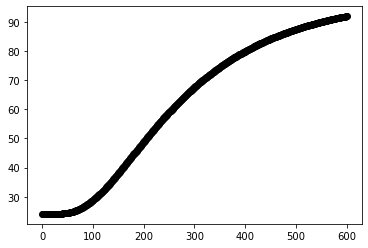

In [14]:
# run simulation again, save results at times for data
# using T0 and Tout from data
T0 = 24.1
Tout = 98.5
start = time.perf_counter()
    
temp = np.zeros((n,n,n)) + T0

Tsim = []             # set up array to store simulated temperature to compare with data
tSim = []             # set up array to store simulation times

t = 0
    
# set up the kernel for the convolution
p = np.zeros((3,3,3))
p[1][1][1] = -6
for i in [0,2]:
    p[i][1][1] = 1
    p[1][i][1] = 1
    p[1][1][i] = 1
p *= alpha
p[1][1][1] += 1

while t <= 600:                       # temp[int(n/2)][int(n/2)][int(n/2)] <= Tfinal:    
    Tsim.append(temp[int(n/2)][int(n/2)][int(n/2)])
    tSim.append(t)
    oldTemp = temp.copy()
    temp = im.convolve(temp,p,mode='nearest')
    
    temp[0,:,:] += convect*(Tout - oldTemp[0,:,:])
    temp[-1:,:,:] += convect*(Tout - oldTemp[0,:,:])
    temp[:,-1,:] += convect*(Tout - oldTemp[0,:,:])
    temp[:,0,:] += convect*(Tout - oldTemp[0,:,:])
    temp[:,:,-1] += convect*(Tout - oldTemp[0,:,:])
    temp[:,:,0] += convect*(Tout - oldTemp[0,:,:])

    t += dt

stop = time.perf_counter()
print("running time",stop-start,"s")
plt.plot(tSim,Tsim,'ko')
print("cooking time",t,"seconds")

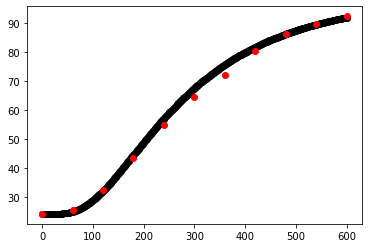

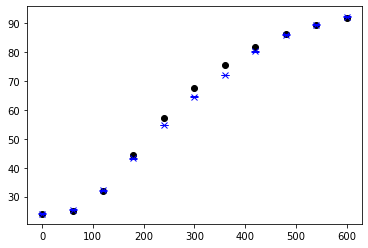

chi squared is 3016.7641201180786
conductivity is 0.47 and convection coefficient is 1500


In [15]:
# plot simulation and data, and calculate chi-squared
# this example shows how the simulation is sliced when the data time step is smaller than the simulation time step.
plt.plot(tSim,Tsim,'ko')
plt.plot(timeData,tempData,'ro')
plt.show()

uncT = 0.1           # uncertainty of temperature measurements
T_uncert = np.full((len(timeData)),uncT)

tSimA = np.array(tSim)
TsimA = np.array(Tsim)

# pick out the simulation points at the times of the data points
mask = np.isin(tSim,timeData)
tSimMeas = tSimA[mask]
TsimMeas = TsimA[mask]
plt.plot(tSimMeas,TsimMeas,'ko')
plt.errorbar(timeData,tempData,yerr = T_uncert,fmt='bx',capsize=4)
plt.show()

chi2 = np.sum(((TsimMeas-tempData)/T_uncert)**2)                  # uses vectorization
print("chi squared is",chi2)
print("conductivity is",kth,"and convection coefficient is",h)

Use this cell to keep track of the changes and chi-squared achieved.

For completeness, loop over conductivity and convection coefficients, to identify the lowest chi-squared.

0.44 1490 1596.6923798984376
0.44 1500 1582.0218654428268
0.44 1510 1567.720025737816
0.45 1490 1013.6035621910753
0.45 1500 1013.1394249105318
0.45 1510 1012.86522625009
0.46 1490 1508.6230756713298
0.46 1500 1522.2826027009569
0.46 1510 1535.9542651885731
best kth 0.45
best h 1510


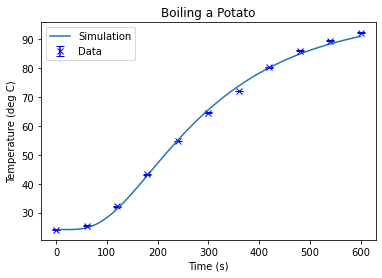

In [9]:
# temporary change to look at parameter uncertainty

specHeat = 3390    # specific heat, J/(kg*K)
T0 = 24.1           # initial temperature, deg C
Tout = 98.5          # outside temperature, deg C
L = 0.038          # length, m
density = 630       # density, kg/m^3
Tfinal = 99       # ending temperature, deg C

dt = 1            # time step, s
n = 11           # number of position chunks
dx = L / n          # distance chunk, m
    
uncT = 0.1           # uncertainty of temperature measurements
T_uncert = np.full((len(timeData)),uncT)
    
# set up the structure of the kernel for the convolution
pp = np.zeros((3,3,3))
pp[1][1][1] = -6
for i in [0,2]:
    pp[i][1][1] = 1
    pp[1][i][1] = 1
    pp[1][1][i] = 1
    
    
first = True            # flag for first iteration, for purposes of tracking min chi2
TBestSim = np.zeros((n,n,n)) + T0       # storage for temps for current min chi2

tSim = []             # set up array to store simulation times
    
    # begin loops over h and kth

# comments show first pass, values show refined numbers
    
kthlow = 0.44       # 0.35
kthhigh = 0.46      # 0.6
del_kth = 0.01      # 0.1
nkth = int((kthhigh-kthlow)/del_kth) + 1

hlow = 1490         # 500
hhigh = 1510       # 2000
del_h = 10       # 100

for kth in np.linspace(kthlow,kthhigh,nkth):
    for h in range(hlow,hhigh+del_h,del_h):

        
# indent following lines twice

        alpha = dt * kth / (specHeat * density * dx**2)    # exercise: derive this
        convect = h * dt / (specHeat * density * dx)

        if alpha > 0.5 or convect > 0.5:
            print("results may be unstable, reduce time step")

        temp = np.zeros((n,n,n)) + T0

        Tsim = []             # set up array to store simulated temperature at selected point to compare with data

        t = 0

        alpha = dt * kth / (specHeat * density * dx**2)    # exercise: derive this
        convect = h * dt / (specHeat * density * dx)

        if alpha > 0.5 or convect > 0.5:
            print("results may be unstable, reduce time step")
        
        # finish setup of kernel for convolution
        p = alpha * pp
        p[1][1][1] += 1

        while t <= 600:                       # temp[int(n/2)][int(n/2)][int(n/2)] <= Tfinal:    
            Tsim.append(temp[int(n/2)][int(n/2)][int(n/2)])   # assuming measuring at center of cube
            if first:
                tSim.append(t)
            oldTemp = temp.copy()
            temp = im.convolve(temp,p,mode='nearest')
    
            temp[0,:,:] += convect*(Tout - oldTemp[0,:,:])
            temp[-1:,:,:] += convect*(Tout - oldTemp[0,:,:])
            temp[:,-1,:] += convect*(Tout - oldTemp[0,:,:])
            temp[:,0,:] += convect*(Tout - oldTemp[0,:,:])
            temp[:,:,-1] += convect*(Tout - oldTemp[0,:,:])
            temp[:,:,0] += convect*(Tout - oldTemp[0,:,:])

            t += dt

        if first:
            tSimA = np.array(tSim)
            mask = np.isin(tSim,timeData)
            tSimMeas = tSimA[mask]

        TsimA = np.array(Tsim)

        # pick out the simulation points at the times of the data points

        TsimMeas = TsimA[mask]

        chi2 = np.sum(((TsimMeas-tempData)/T_uncert)**2)                  # uses vectorization
        
        # for paremeter uncertainty
        print(kth,h,chi2)
        
        if first:
            min_chi2 = chi2
            TBestSim = Tsim
            kthBest = kth
            hBest = h
            first = False
        else:
            if chi2 < min_chi2:
                min_chi2 = chi2
                TBestSim = Tsim
                kthBest = kth
                hBest = h


print("best kth", kthBest)
print("best h", hBest)
plt.errorbar(timeData,tempData,yerr = T_uncert,fmt='bx',capsize=4,label="Data")
plt.plot(tSim,TBestSim,label="Simulation")
plt.title("Boiling a Potato")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (deg C)")
plt.legend()
plt.show()


Exercise:  After the best values are found, vary kth and h to find their uncertainty using the criterion that the chi-squared will change by one.

<i>Written by Michael Burns-Kaurin, Spelman College, July 2021.<br><br>This material is based on work supported by the Atlanta University Center Data Science
Initiative and by the Partnership for Integration of Computation into Undergraduate Physics.</i>